#**Digit Prediction from Recorded Speech Audio**

We are going to use audio files that record different speakers saying numerical digits. This type of NN could be useful for detecting spoken digits in an audio-based customer service setting with a voice-based chatbot. First, we need to download the data.

In [2]:
!git clone https://github.com/Jakobovski/free-spoken-digit-dataset

fatal: destination path 'free-spoken-digit-dataset' already exists and is not an empty directory.


We can play one of these files to hear what it sounds like... this person is saying the digit 'zero'.

free-spoken-digit-dataset/recordings/7_theo_46.wav


Total Duration: 0.3825 seconds.


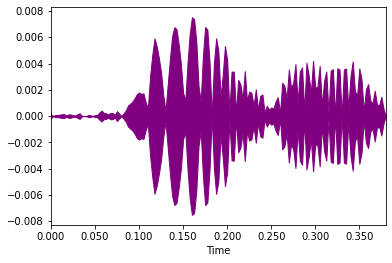

In [3]:
from IPython.display import Audio
from IPython.display import display
import glob
import librosa.display
import librosa
   
basePath = 'free-spoken-digit-dataset/recordings'

for i,file in enumerate(glob.glob(f"{basePath}/*.wav")):
  
  # What's the name of the file? 
  sound_file = f'{file}'
  print(sound_file)

  # Play the audio file.
  wn = Audio(sound_file, autoplay=True) ##
  display(wn)

  # Draw the waveform plot of the audio signal.
  y,sr=librosa.load(sound_file, sr=400) # I am going to be downsampling these files from 8kHz to 400Hz.
  librosa.display.waveplot(y,sr=sr, x_axis='time', color='purple',offset=0.0)

  # Write out how long the file is in seconds.
  print(f'Total Duration: {librosa.get_duration(y=y,sr=sr)} seconds.')

  break

What does .wav data actually look like?

In [4]:
from scipy.io import wavfile

sampling_rate, data = wavfile.read(sound_file) 
print(f'Song is originally sampled at {sampling_rate} times per second.')
print(f'The file contains a total of {len(data)} samples, thus the song length is {len(data)/sampling_rate} seconds.')
print(f'Here are the first 15 samples...{data[:15]}.')

Song is originally sampled at 8000 times per second.
The file contains a total of 3050 samples, thus the song length is 0.38125 seconds.
Here are the first 15 samples...[  3 -26 -18  -2 -11  13  10   3 -15 -11  -3  -8 -11 -36   2].


#*Prepare Our Data*



For each song, let's convert it into numeric sequences, and construct its label from the file name.


In [5]:
from pathlib import Path
from scipy.signal import decimate

downsample_factor = 8

def processSong(song):
  
  filename = Path(song).stem
  label = int(filename[0])

  sampling_rate, data = wavfile.read(song)
  return label,sampling_rate,data

labels = []
sample_rates = []
sequences = []

for i,file in enumerate(glob.glob(f"{basePath}/*.wav")):
  label, sample_rate, sequence = processSong(file)
  labels.append(label)
  sample_rates.append(sample_rate/downsample_factor)

  sequence = decimate(sequence,downsample_factor) 

  sequences.append(sequence)

sequences[0]

array([ 2.26849347e+00, -6.28884932e+00, -7.40036169e+00,  5.37429255e+00,
        9.68750121e+00, -4.29158399e+00, -1.71139869e+00,  2.56898357e+00,
       -1.60278683e+00, -5.00116300e+00, -8.94664180e+00,  5.10246238e+00,
       -4.51458640e+00, -1.52605454e+01,  2.03604938e+00, -4.03983756e+00,
       -1.68627277e+00, -5.25303136e+00, -5.98496791e+00,  4.51869440e+00,
       -2.14335676e+00, -6.74364012e+00, -1.41382952e+01,  2.29419748e+00,
        8.88909391e+00, -3.82340000e+00, -3.02627080e+00,  3.04283693e+00,
        1.04421627e+01, -1.04428077e+00,  6.92891670e-01,  4.92062127e+00,
       -5.85829973e+00, -7.77321480e+00, -6.18633427e+00,  5.33467242e+00,
        6.07673961e-01, -2.34819183e+00,  4.40698644e+00, -4.29405453e+00,
        1.88383468e+00,  1.27995949e-01, -7.23223775e+00, -5.14734522e-01,
        1.35223565e+00,  3.89335592e+00, -1.48172646e-01, -2.15453465e+00,
        2.76928260e+00,  9.55928742e-01, -6.25366742e+00, -2.58074632e-03,
        6.15725499e+00, -

All songs have been 'downsampled'. We have ragged lists of numeric values that we need to pad.

In [6]:
for i in range(3):
  print(f'Recording {i} has a sampling rate of {sample_rates[i]}, and it is {len(sequences[i])} elements long.')

Recording 0 has a sampling rate of 1000.0, and it is 382 elements long.
Recording 1 has a sampling rate of 1000.0, and it is 161 elements long.
Recording 2 has a sampling rate of 1000.0, and it is 326 elements long.


Here we will make an array of 0's and fill in our audio sequences from the left. The longest sequence is an outlier, so we will truncate some recordings.


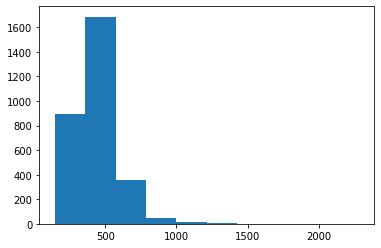

The longest list is 2283 long, but most lists are much shorter.
(3000, 700)


In [7]:
import tensorflow as tf
import numpy as np
import statistics
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler

len_lists = [len(x) for x in sequences]
plt.hist(len_lists)
plt.show()
print(f'The longest list is {max(len_lists)} long, but most lists are much shorter.')

# We can pad the sequences to have a common length (and chop off the end of really long ones)
labels = np.stack(labels)

# Be careful with this pad sequences function! By default it pads at the front...
# If you pad the wrong end and then truncate that can have a huge impact on model accuracy (e.g., 10%)
padded_sequences = sequence.pad_sequences(sequences, maxlen=700,padding="post")  

# We might use a min-max scaler here to whiten our data. Note that audio data is already generally centered around 0 though! So, it's not that important. 
#scaler = MinMaxScaler(feature_range=(-1, 1))
#scaler = scaler.fit(padded_sequences)
#padded_sequences = scaler.transform(padded_sequences)

# Shuffling observations, because certain voices come earlier in the file system, and others later.
shuffled_indices= np.arange(padded_sequences.shape[0])
np.random.shuffle(shuffled_indices)
padded_sequences = padded_sequences[shuffled_indices,:]
labels = labels[shuffled_indices]

print(padded_sequences.shape)

In [ ]:
padded_sequences[0]

array([ 1.76399598e-01, -2.25250086e-01,  1.86383640e-02, -2.50257315e-01,
       -9.63362284e-02,  4.37638143e-01,  7.42049470e-02, -1.39411062e-01,
        2.60889251e-01,  6.69030733e-02,  3.00895797e-02, -2.61566127e-03,
        2.67634431e-01, -8.19672131e-03, -2.27375566e-01,  8.63191018e-02,
        1.53485013e-01,  1.40626348e-02,  1.88309286e-01,  1.16450261e-01,
        8.78222595e-02, -2.11892367e-02,  1.89893040e-01, -3.84882376e-02,
        2.65381209e-01, -4.25343732e-02,  2.27495430e-01, -5.29487731e-02,
        9.16030534e-03, -1.69631170e-01,  1.50189176e-01, -1.51329978e-01,
        5.76271186e-02,  5.26410027e-02, -3.43591741e-02,  2.74020604e-02,
        7.11813492e-03,  5.84277377e-02,  1.72979798e-01, -1.02103098e-01,
        7.02532121e-02,  2.63745127e-01,  7.15837914e-03, -3.63942494e-02,
        2.13302308e-03,  4.99515347e-02, -4.70707755e-02,  1.66993281e-01,
        1.15320566e-01, -9.34084134e-03,  7.83933876e-02, -8.96734533e-03,
        5.07897527e-03,  

#*Temporal (1D) Convolutions*

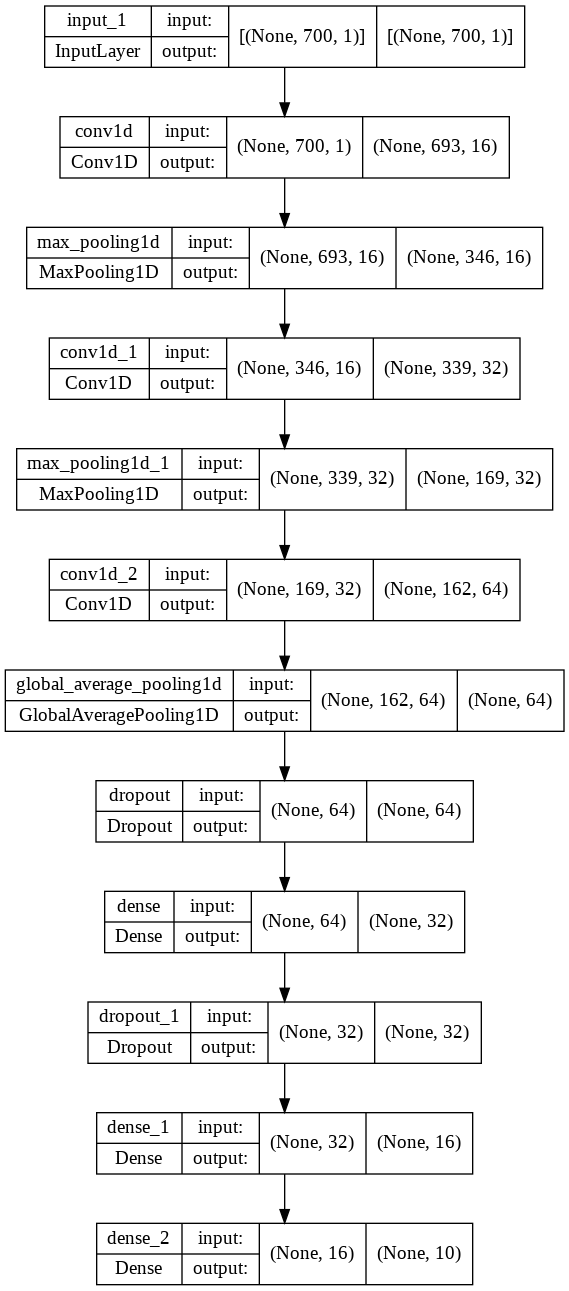

In [8]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(padded_sequences.shape[1], 1))
x = layers.Conv1D(16, 8, activation="relu")(inputs) # 1D Convolution with 16 channels / filters, and a window length of 8 (kernel size). Stride here is 1, no padding. 
x = layers.MaxPooling1D(2)(x) # Then we apply max pooling, with window of 2 (and stride of 2)
x = layers.Conv1D(32, 8, activation="relu")(x) # Then 32 filters, window of 8. 
x = layers.MaxPooling1D(2)(x) # Pool by blocks of two values in each sequence (again, means we attempt to divide sequence length in half)
x = layers.Conv1D(64, 8, activation="relu")(x) # Again 64 filters, with sequence length of 8 this time.
x = layers.GlobalAveragePooling1D()(x) # We apply global average pooling to the resulting 64 feature maps (i.e., what high level patterns were more or less present across the series)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32,activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(16,activation="relu")(x)
outputs = layers.Dense(10,activation="softmax")(x) # Linear activation output.
model = keras.Model(inputs, outputs)
  
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
keras.utils.plot_model(model,show_shapes=True)

Let's try fitting this model... 

In [9]:
# We are making a different callback so we don't overwrite our last model (we might want to compare them)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="audio_conv.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(padded_sequences,labels,validation_split=0.2,batch_size=25,epochs=200,callbacks=callbacks)

Epoch 1/200
96/96 [==============================] - 11s 10ms/step - loss: 6.9842 - sparse_categorical_accuracy: 0.1021 - val_loss: 2.3690 - val_sparse_categorical_accuracy: 0.1167
Epoch 2/200
96/96 [==============================] - 1s 5ms/step - loss: 2.3362 - sparse_categorical_accuracy: 0.1079 - val_loss: 2.2615 - val_sparse_categorical_accuracy: 0.1333
Epoch 3/200
96/96 [==============================] - 0s 5ms/step - loss: 2.2897 - sparse_categorical_accuracy: 0.1171 - val_loss: 2.2745 - val_sparse_categorical_accuracy: 0.1467
Epoch 4/200
96/96 [==============================] - 0s 5ms/step - loss: 2.2921 - sparse_categorical_accuracy: 0.1433 - val_loss: 2.2759 - val_sparse_categorical_accuracy: 0.1600
Epoch 5/200
96/96 [==============================] - 0s 5ms/step - loss: 2.2594 - sparse_categorical_accuracy: 0.1617 - val_loss: 2.2296 - val_sparse_categorical_accuracy: 0.1550
Epoch 6/200
96/96 [==============================] - 0s 5ms/step - loss: 2.2436 - sparse_categorical_ac

If we plot model accuracy over training...

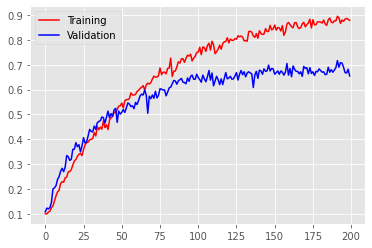

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['sparse_categorical_accuracy'],c="r")
plt.plot(history.history['val_sparse_categorical_accuracy'],c="b")
plt.legend(['Training','Validation'])
plt.show()

#*Now Let's Try LSTM*

These sequences are quite long, so you'll find that the LSTM trains very slowly, unless you use very large batches. This is limiting, because learning might improve with smaller batch sizes.

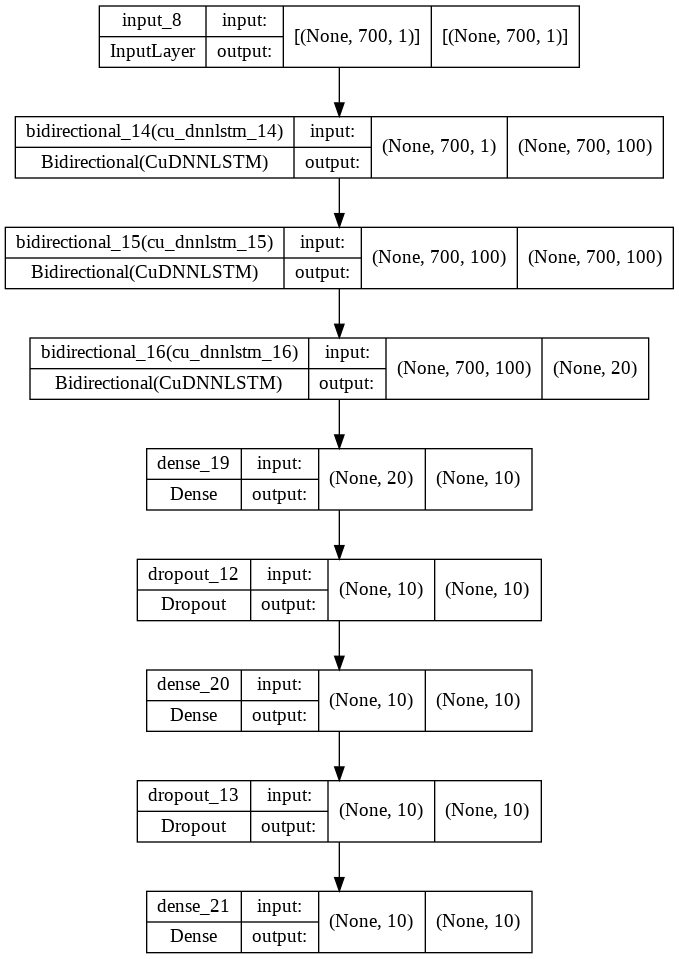

In [ ]:
from tensorflow import keras
from keras import layers

input = keras.Input(shape=(padded_sequences.shape[1],1)) 
masking_layer = layers.Masking()(input) # Ignore the zero padding.

# Note: We shouldn't use BatchNormalization() with sequence data, because it is not effective / can be harmful. 
# Layer normalization is a better alternative; it normalizes values in a sequence on a per-sequence basis (rather than across sequences in the batch).
# There is a tensorflow add-on (tfa library) layer that provides an LSTM layer that incorporates layer-normalization, if you want to try it out.

# If we were to say "return_sequences=True", then this LSTM would return transformations of the sequence (rather than a compressed representation)
# Each LSTM unit will push the sequence of 700 values through a series of recurring LSTM calculations.
# Each LSTM unit will produce a compressed representation of the sequence. If we have 10 LSTM units, we get 10 representations (think of this as a 10-dim embedding of the audio sequence)
# The layer is bi-directional, so we get 2* the number of LSTM outputs, one in each direction, concatenated together, so actually a 20 dim embedding of the audio sequence.
#x = layers.Bidirectional(layers.LSTM(units=10))(masking_layer) 
x = layers.Bidirectional(layers.CuDNNLSTM(units=50,return_sequences=True))(input) 
x = layers.Bidirectional(layers.CuDNNLSTM(units=50,return_sequences=True))(x) 
x = layers.Bidirectional(layers.CuDNNLSTM(units=10))(x) 

# Then I'm passing that to a couple of Dense layers that can figure out how to mix and match and recombine the embedding.
# Add some dropout so it doesn't start to overfit immediately
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(10, activation="relu")(x)
x = layers.Dropout(0.3)(x)

# Finally, we pass the result to a 10-digit softmax output.
output = layers.Dense(10,activation="softmax")(x)

model = keras.Model(inputs=input,outputs=output)

model.compile(optimizer="rmsprop",loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])

keras.utils.plot_model(model,show_shapes=True)

Let's try fitting this model... this approach alone (of learning compressed representations, i.e., embeddings, of the audio sequence) is sufficient to get us to 50% accuracy in our classification task. That's impressive, or it's not, depending on how you think about it. 

In [ ]:
# We are making a different callback so we don't overwrite our last model (we might want to compare them)
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="audio_digits.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(padded_sequences,labels,validation_split=0.2,batch_size=25,epochs=250,callbacks=callbacks)

Epoch 1/250
96/96 [==============================] - 26s 216ms/step - loss: 2.3040 - sparse_categorical_accuracy: 0.0950 - val_loss: 2.3044 - val_sparse_categorical_accuracy: 0.0850
Epoch 2/250
96/96 [==============================] - 20s 206ms/step - loss: 2.3031 - sparse_categorical_accuracy: 0.0992 - val_loss: 2.2993 - val_sparse_categorical_accuracy: 0.0833
Epoch 3/250
96/96 [==============================] - 20s 207ms/step - loss: 2.2964 - sparse_categorical_accuracy: 0.1075 - val_loss: 2.2950 - val_sparse_categorical_accuracy: 0.0817
Epoch 4/250
96/96 [==============================] - 20s 206ms/step - loss: 2.2863 - sparse_categorical_accuracy: 0.1108 - val_loss: 2.2802 - val_sparse_categorical_accuracy: 0.1183
Epoch 5/250
96/96 [==============================] - 20s 209ms/step - loss: 2.2709 - sparse_categorical_accuracy: 0.1250 - val_loss: 2.2530 - val_sparse_categorical_accuracy: 0.1450
Epoch 6/250
96/96 [==============================] - 20s 207ms/step - loss: 2.2602 - spars

KeyboardInterrupt: ignored

Plot loss and accuracy over training... the model peaks at about 60% accuracy as well, so no better. 

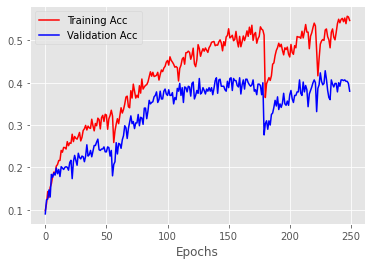

In [ ]:
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

plt.plot(history.history['sparse_categorical_accuracy'],c="r")
plt.plot(history.history['val_sparse_categorical_accuracy'],c='b')
plt.xlabel("Epochs")
plt.legend(['Training Acc','Validation Acc'])
plt.show()